In [1]:
# EXPLORED MODEL
# Decision Tree

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve
from sklearn.metrics import RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [8]:
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

df_train = pd.read_csv("adult/adult.data", header=None, names=column_names)
df_test = pd.read_csv('adult/adult.test', header=None, names=column_names, skiprows=1)
print("Training data shape:", df_train.shape)
print("Testing data shape:", df_test.shape)
print(f'{df_train.info()}')

Training data shape: (32561, 15)
Testing data shape: (16281, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None


In [9]:
print(f'First 5 rows of training data:\n{df_train.head()}')
print(df_train['income'].value_counts())
print(df_test['income'].value_counts())

First 5 rows of training data:
   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0        

In [10]:
def clean_adult_data(df):
    df = df.copy()
    df['income'] = (
        df['income']
        .str.strip()
        .str.replace('.', '', regex=False)
        .str.lower()
    )
    df.replace('?', np.nan, inplace=True)
    return df


df_train = clean_adult_data(df_train)
df_test = clean_adult_data(df_test)

print(df_train.isnull().sum())
print(df_test.isnull().sum())
print(df_train['income'].unique())


age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64
['<=50k' '>50k']


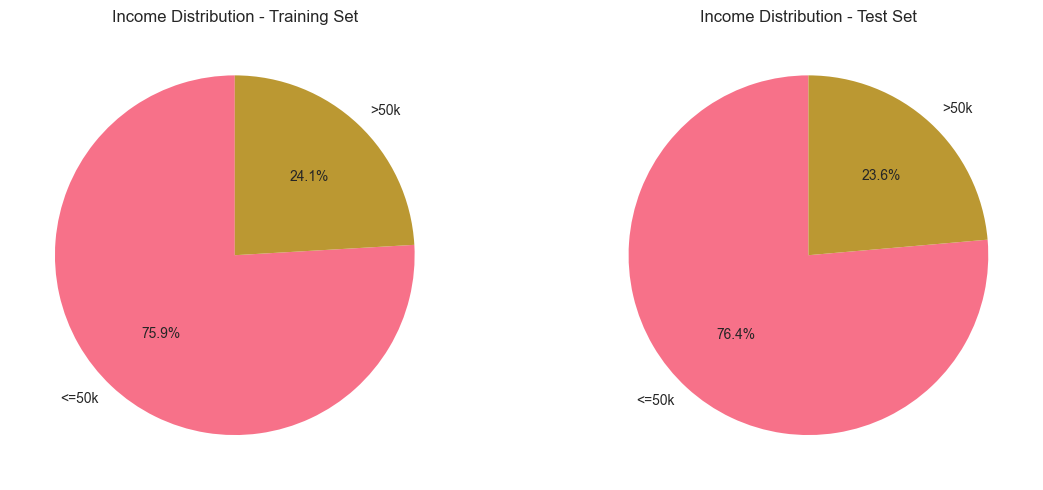

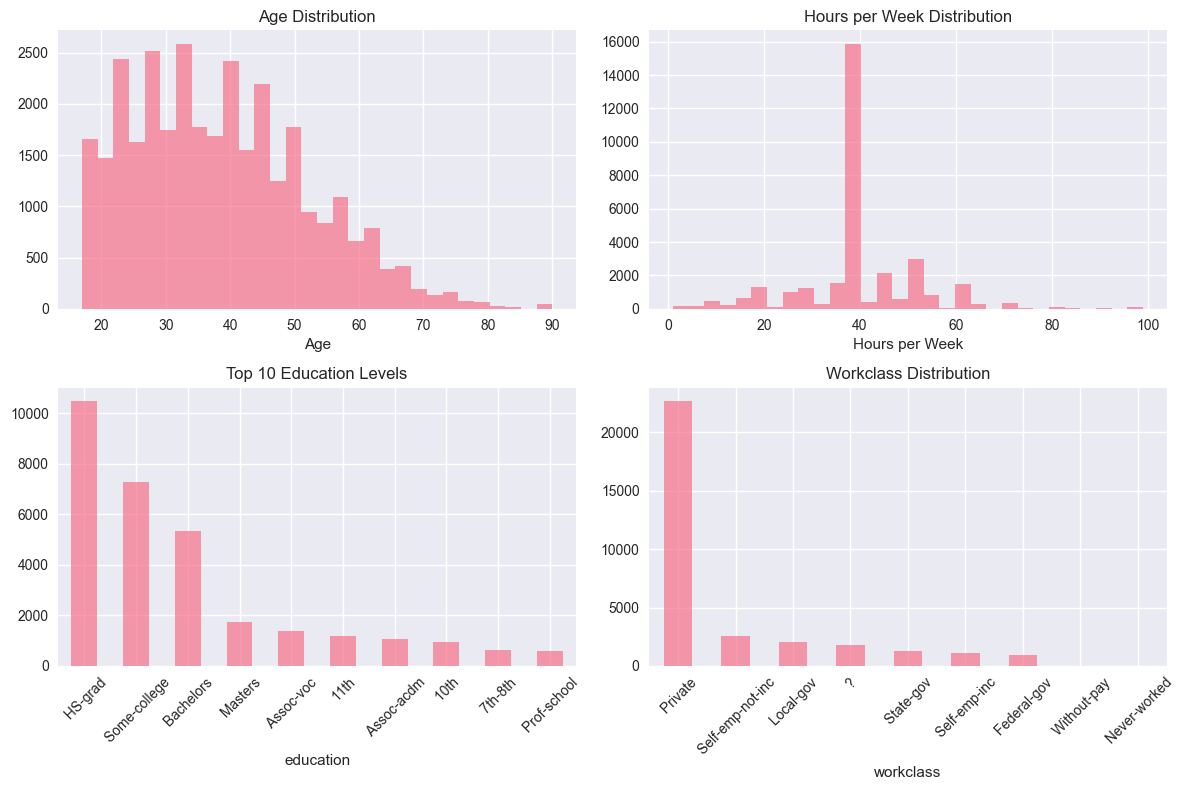

In [11]:
# Visualizating key distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

train_income_counts = df_train['income'].value_counts()
ax1.pie(train_income_counts.values, labels=train_income_counts.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Income Distribution - Training Set')

test_income_counts = df_test['income'].value_counts()
ax2.pie(test_income_counts.values, labels=test_income_counts.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Income Distribution - Test Set')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

df_train['age'].hist(bins=30, ax=axes[0,0], alpha=0.7)
axes[0,0].set_title('Age Distribution')
axes[0,0].set_xlabel('Age')

df_train['hours-per-week'].hist(bins=30, ax=axes[0,1], alpha=0.7)
axes[0,1].set_title('Hours per Week Distribution')
axes[0,1].set_xlabel('Hours per Week')

df_train['education'].value_counts().head(10).plot(kind='bar', ax=axes[1,0], alpha=0.7)
axes[1,0].set_title('Top 10 Education Levels')
axes[1,0].tick_params(axis='x', rotation=45)

df_train['workclass'].value_counts().plot(kind='bar', ax=axes[1,1], alpha=0.7)
axes[1,1].set_title('Workclass Distribution')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [12]:
X_train = df_train.drop('income', axis=1)
y_train = df_train['income']
X_test = df_test.drop('income', axis=1)
y_test = df_test['income']
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (32561, 14), y_train shape: (32561,)
X_test shape: (16281, 14), y_test shape: (16281,)


In [13]:
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 
                        'race','sex', 'native-country']
numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 
                      'capital-loss', 'hours-per-week']

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', ))
])
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

X_train_pr = preprocessor.fit_transform(X_train)
X_test_pr = preprocessor.transform(X_test)
print(f'Preprocessed X_train shape: {X_train_pr.shape}')
print(f'Preprocessed X_test shape: {X_test_pr.shape}')


Preprocessed X_train shape: (32561, 108)
Preprocessed X_test shape: (16281, 108)


In [43]:
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
dt_pipeline.fit(X_train, y_train)
y_pred = dt_pipeline.predict(X_test)
y_proba = dt_pipeline.predict_proba(X_test)[:, 1]

dt_accuracy = accuracy_score(y_test, y_pred)
dt_auc = roc_auc_score(y_test, y_proba)
print(f'Decision Tree Accuracy: {dt_accuracy:.4f}')
print(f'Decision Tree AUC: {dt_auc:.4f}')
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Training Score with Best Parameters:", dt_pipeline.score(X_train, y_train))
print("Validation Score with Best Parameters:", dt_pipeline.score(X_test, y_test))

Decision Tree Accuracy: 0.8100
Decision Tree AUC: 0.7429
Classification Report:
               precision    recall  f1-score   support

       <=50k       0.88      0.87      0.87     12435
        >50k       0.59      0.62      0.60      3846

    accuracy                           0.81     16281
   macro avg       0.74      0.74      0.74     16281
weighted avg       0.81      0.81      0.81     16281

Training Score with Best Parameters: 0.9999692884125181
Validation Score with Best Parameters: 0.8100239543025612


In [17]:
default_dt = dt_pipeline.named_steps['classifier']
print("Default Decision Tree Parameters: ", default_dt.get_params())
print("Decision Tree Depth:", default_dt.get_depth())
print("Number of Leaves:", default_dt.get_n_leaves())
print("# of Features Used: ", np.sum(default_dt.feature_importances_ > 0))
print("Max Features in Tree:", len(default_dt.feature_importances_))

Default Decision Tree Parameters:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
Decision Tree Depth: 49
Number of Leaves: 4682
# of Features Used:  94
Max Features in Tree: 108


In [42]:
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 8],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
print("Best Parameters from Grid Search:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)
# print train score and Validation score
print("Training Score with Best Parameters:", grid_search.score(X_train, y_train))
print("Validation Score with Best Parameters:", grid_search.score(X_test, y_test))

Fitting 5 folds for each of 672 candidates, totalling 3360 fits
Best Parameters from Grid Search: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 20}
Best Cross-Validation Score: 0.8572527124922334
Training Score with Best Parameters: 0.8662817481035595
Validation Score with Best Parameters: 0.8621092070511639


In [50]:
best_dt_model = grid_search.best_estimator_
y_pred_best = best_dt_model.predict(X_test)
y_proba_best = best_dt_model.predict_proba(X_test)[:, 1]

dt_accuracy_best = accuracy_score(y_test, y_pred_best)
dt_auc_best = roc_auc_score(y_test, y_proba_best)

print(f'Decision Tree (Tuned) Accuracy: {dt_accuracy_best:.4f}')
print(f'Decision Tree (Tuned) AUC: {dt_auc_best:.4f}')
print("Classification Report (Tuned):\n", classification_report(y_test, y_pred_best))

print("Improvement after Hyperparameter Tuning:\n")
print(f'Accuracy Improvement: {dt_accuracy_best - dt_accuracy:.4f}')
print(f'AUC Improvement: {dt_auc_best - dt_auc:.4f}')

Decision Tree (Tuned) Accuracy: 0.8621
Decision Tree (Tuned) AUC: 0.9055
Classification Report (Tuned):
               precision    recall  f1-score   support

       <=50k       0.88      0.94      0.91     12435
        >50k       0.77      0.60      0.67      3846

    accuracy                           0.86     16281
   macro avg       0.83      0.77      0.79     16281
weighted avg       0.86      0.86      0.86     16281

Improvement after Hyperparameter Tuning:

Accuracy Improvement: 0.0521
AUC Improvement: 0.1626


Top 10 Feature Importances:


,Feature,Importance
33,marital-status_ Married-civ-spouse,0.393355
2,education-num,0.212029
3,capital-gain,0.192884
4,capital-loss,0.064779
0,age,0.046591
5,hours-per-week,0.032952
42,occupation_ Exec-managerial,0.011967
1,fnlwgt,0.010400
12,workclass_ Self-emp-not-inc,0.006551
48,occupation_ Prof-specialty,0.005889


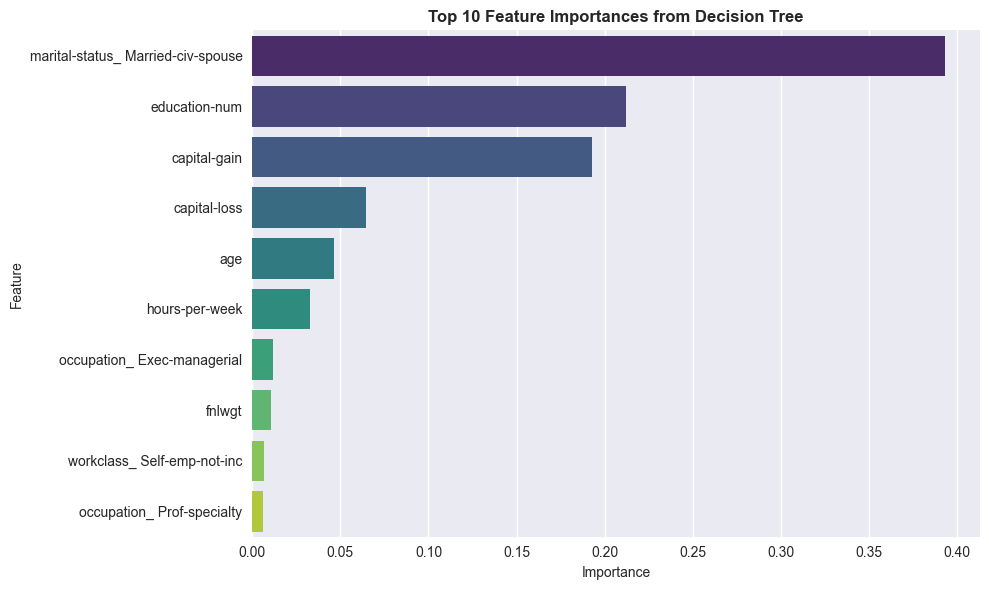

In [26]:
preprocessor_fitted = best_dt_model.named_steps['preprocessor']
ohe = preprocessor_fitted.named_transformers_['cat'].named_steps['encoder']
feature_names_num = list(numerical_features) + list(ohe.get_feature_names_out(categorical_features))

importances = best_dt_model.named_steps['classifier'].feature_importances_

df_importances = pd.DataFrame({
    'Feature': feature_names_num,
    'Importance': importances
})
df_importances = df_importances.sort_values(by='Importance', ascending=False)
top_features = df_importances.head(10)
print("Top 10 Feature Importances:")
display(top_features)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importances from Decision Tree', fontsize=12, fontweight='bold')
plt.xlabel('Importance', fontsize=10)
plt.ylabel('Feature', fontsize=10)
plt.tight_layout()
plt.show()

Tuned Decision Tree Parameters:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
Decision Tree Depth: 10
Number of Leaves: 219


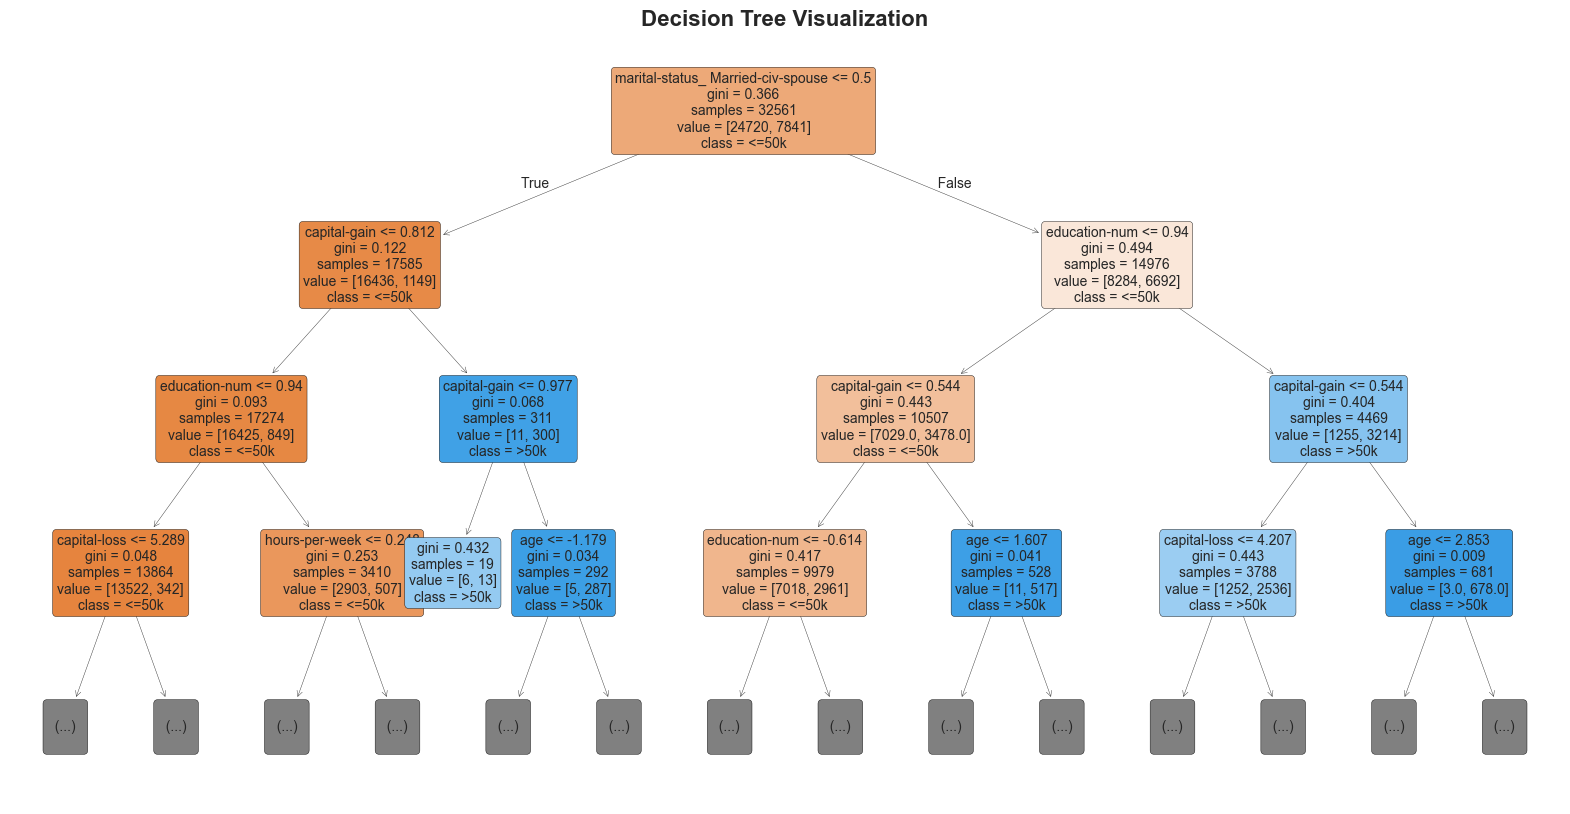

In [35]:
tuned_dt = best_dt_model.named_steps['classifier']
print("Tuned Decision Tree Parameters: ", tuned_dt.get_params())
print("Decision Tree Depth:", tuned_dt.get_depth())
print("Number of Leaves:", tuned_dt.get_n_leaves())

if tuned_dt.get_depth() <= 10:
    plt.figure(figsize=(20, 10))
    plot_tree(tuned_dt, feature_names=feature_names_num, class_names=tuned_dt.classes_, filled=True, rounded=True, max_depth=3, fontsize=10)
    plt.title('Decision Tree Visualization', fontsize=16, fontweight='bold')
    plt.show()

else:
    print("Decision tree is too deep to visualize effectively.")
    plt.figure(figsize=(20, 10))
    plot_tree(tuned_dt, feature_names=feature_names_num, class_names=tuned_dt.classes_, filled=True, rounded=True, max_depth=3, fontsize=10)
    plt.title('Top 3 Levels of Decision Tree Visualization', fontsize=16, fontweight='bold')
    plt.show()

In [36]:
tb_tree = export_text(tuned_dt, feature_names=feature_names_num, max_depth=3, decimals=2)
print("Decision Tree Rules (Top 3 Levels):\n")
print(tb_tree)

Decision Tree Rules (Top 3 Levels):

|--- marital-status_ Married-civ-spouse <= 0.50
|   |--- capital-gain <= 0.81
|   |   |--- education-num <= 0.94
|   |   |   |--- capital-loss <= 5.29
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- capital-loss >  5.29
|   |   |   |   |--- truncated branch of depth 4
|   |   |--- education-num >  0.94
|   |   |   |--- hours-per-week <= 0.25
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- hours-per-week >  0.25
|   |   |   |   |--- truncated branch of depth 7
|   |--- capital-gain >  0.81
|   |   |--- capital-gain <= 0.98
|   |   |   |--- class: >50k
|   |   |--- capital-gain >  0.98
|   |   |   |--- age <= -1.18
|   |   |   |   |--- class: >50k
|   |   |   |--- age >  -1.18
|   |   |   |   |--- truncated branch of depth 3
|--- marital-status_ Married-civ-spouse >  0.50
|   |--- education-num <= 0.94
|   |   |--- capital-gain <= 0.54
|   |   |   |--- education-num <= -0.61
|   |   |   |   |--- truncated branch of 

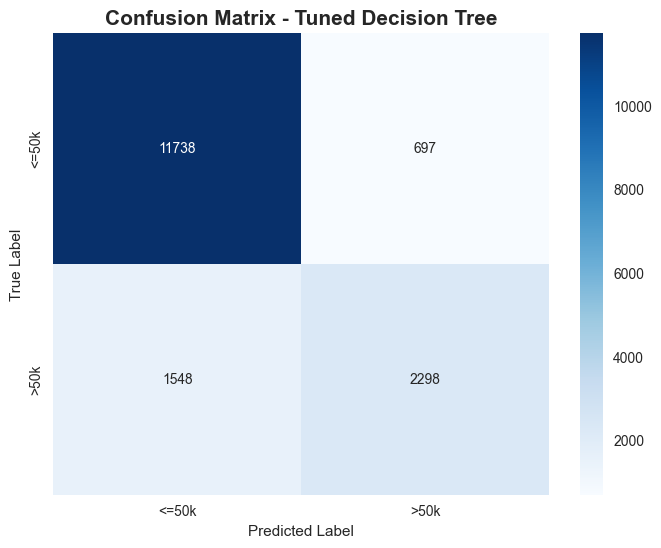

In [37]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best, labels=tuned_dt.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tuned_dt.classes_, yticklabels=tuned_dt.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Tuned Decision Tree', fontsize=15, fontweight='bold')
plt.show()

In [45]:
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1_score:.4f}')

Precision: 0.7673
Recall: 0.5975
F1-Score: 0.6718


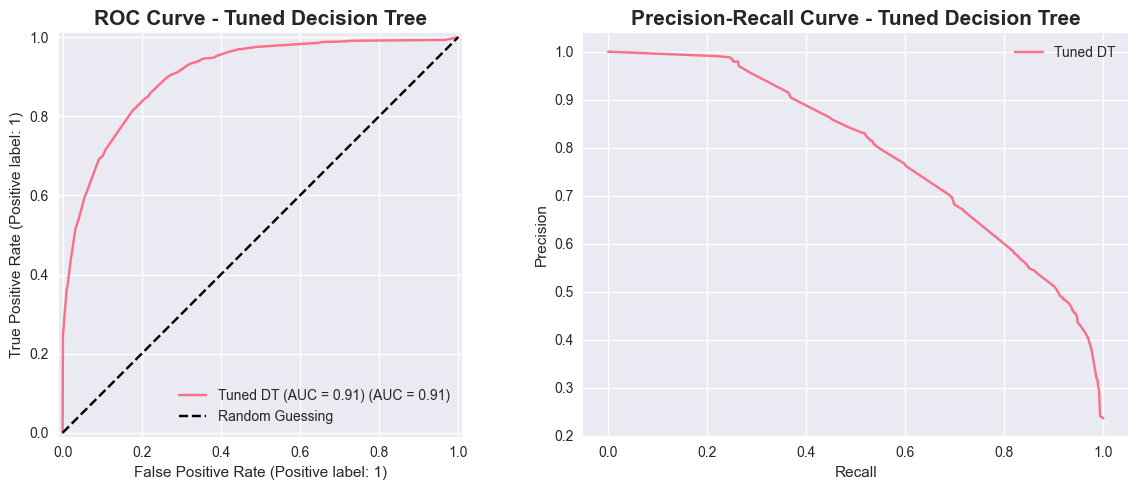

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

y_test_bin = (y_test == '>50k').astype(int)

RocCurveDisplay.from_predictions(y_test_bin, y_proba_best, name=f'Tuned DT (AUC = {dt_auc_best:.2f})', ax=ax1)
ax1.set_title('ROC Curve - Tuned Decision Tree', fontsize=15, fontweight='bold')
ax1.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
ax1.legend()

precision_vals, recall_vals, _ = precision_recall_curve(y_test_bin, y_proba_best)
ax2.plot(recall_vals, precision_vals, label='Tuned DT')
ax2.set_title('Precision-Recall Curve - Tuned Decision Tree', fontsize=15, fontweight='bold')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend()
plt.tight_layout()
plt.show()

Cross-Validation Accuracy Scores: [0.85168125 0.85534398 0.85826167 0.86148649 0.85949017]
Mean CV Accuracy: 0.8573 ± 0.0034


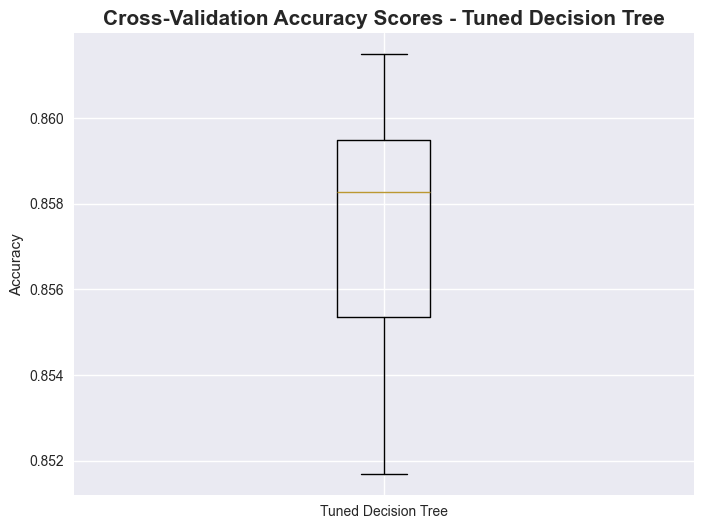

In [47]:
cv_scores = cross_val_score(best_dt_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

plt.figure(figsize=(8, 6))
plt.boxplot(cv_scores, vert=True)
plt.title('Cross-Validation Accuracy Scores - Tuned Decision Tree', fontsize=15, fontweight='bold')
plt.ylabel('Accuracy')
plt.xticks([1], ['Tuned Decision Tree'])
plt.show()

In [48]:
y_pred_train = best_dt_model.predict(X_train)
y_proba_train = best_dt_model.predict_proba(X_train)[:, 1]
train_accuracy = accuracy_score(y_train, y_pred_train)
train_auc = roc_auc_score((y_train == '>50k').astype(int), y_proba_train)
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Training AUC: {train_auc:.4f}')

accuracy_gap = train_accuracy - dt_accuracy_best
auc_gap = train_auc - dt_auc_best
print(f'Accuracy Gap (Train - Test): {accuracy_gap:.4f}')
print(f'AUC Gap (Train - Test): {auc_gap:.4f}')

if accuracy_gap < 0.05 and auc_gap < 0.05:
    print("The model generalizes well with minimal overfitting.")
else:
    print("The model may be overfitting; consider further tuning or regularization.")

Training Accuracy: 0.8663
Training AUC: 0.9242
Accuracy Gap (Train - Test): 0.0042
AUC Gap (Train - Test): 0.0187
The model generalizes well with minimal overfitting.


In [49]:
# Summary of Findings
print('Summary of Findings:')
print(f' - Accuracy improved from {dt_accuracy:.4f} to {dt_accuracy_best:.4f} after hyperparameter tuning.  ')
print(f' - AUC improved from {dt_auc:.4f} to {dt_auc_best:.4f} after hyperparameter tuning.  ')
print(f' - Top predictive features include: {", ".join(top_features["Feature"].values)}.')
print(f' - The confusion matrix indicates {tp} true positives and {fp} false positives.')
print(f' - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}.')
print(f' - Cross-validation shows consistent accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}.')
print(f' - Training vs. Test gaps suggest {"good generalization" if accuracy_gap < 0.05 and auc_gap < 0.05 else "potential overfitting"}.')


Summary of Findings:
 - Accuracy improved from 0.8100 to 0.8621 after hyperparameter tuning.  
 - AUC improved from 0.7429 to 0.9055 after hyperparameter tuning.  
 - Top predictive features include: marital-status_ Married-civ-spouse, education-num, capital-gain, capital-loss, age, hours-per-week, occupation_ Exec-managerial, fnlwgt, workclass_ Self-emp-not-inc, occupation_ Prof-specialty.
 - The confusion matrix indicates 2298 true positives and 697 false positives.
 - Precision: 0.7673, Recall: 0.5975, F1-Score: 0.6718.
 - Cross-validation shows consistent accuracy: 0.8573 ± 0.0034.
 - Training vs. Test gaps suggest good generalization.
